# Experiments for the Eikonal equation in a d-dimensional cube

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_cube import plot_2d_proj
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Cube import data_gen_cube
from NeuralNetworks.NNs import FCFF_3L, FCFF_4L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [17]:
# Dimension of the d-dimensional cube for each experiment
dim_list = 3*[5] + 3*[8]
# Architecture in each experiment
arch_list = [[30,20], 
             [30,20,10],
             [30,20,10],
             [50,40], 
             [40,30,20], 
             [40,30,20]]

n_experiments = len(dim_list)
side_length = 6.


# Parameters for each experiment
delta_list = [[.7, .3, .1, .02]]*n_experiments
alpha_list = [[2.5, 2., 1., .5]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments

num_iterations_list = [[3000, 3000, 3000, 3000],
                       [3000, 3000, 3000, 3000],
                       [3000, 4000, 5000, 8000],
                       [6000, 6000, 6000, 6000],
                       [6000, 6000, 6000, 6000],
                       [6000, 8000, 10000, 16000]]    

100%|██████████| 3000/3000 [00:06<00:00, 482.45it/s]


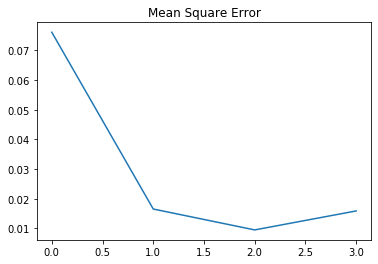

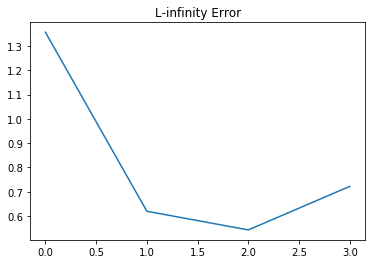

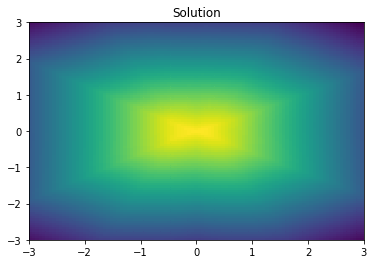

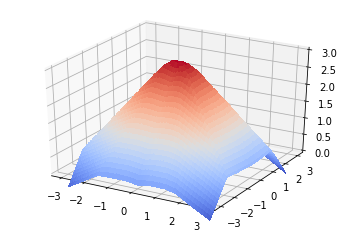

100%|██████████| 3000/3000 [00:07<00:00, 404.32it/s]


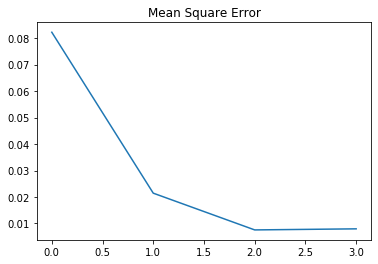

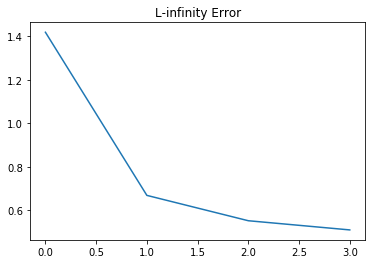

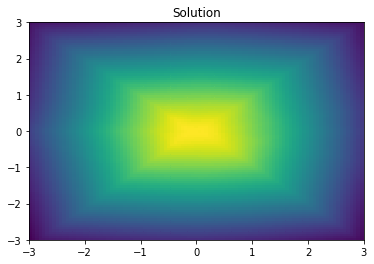

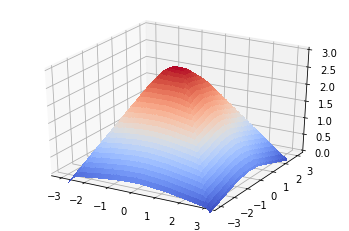

100%|██████████| 8000/8000 [00:17<00:00, 453.61it/s]


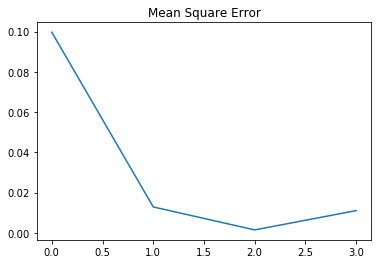

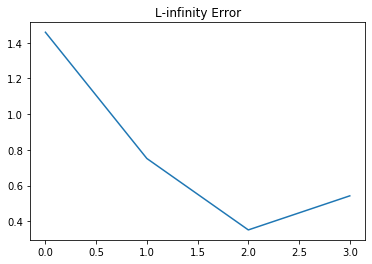

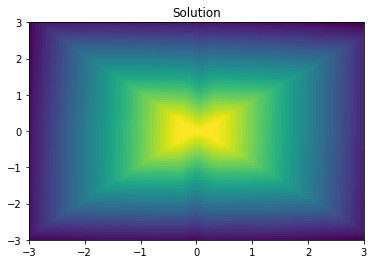

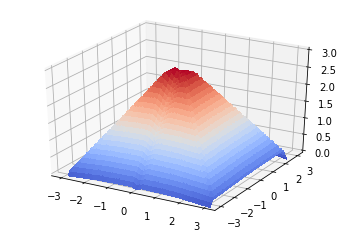

100%|██████████| 6000/6000 [00:16<00:00, 358.71it/s]


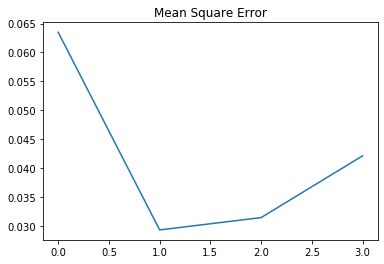

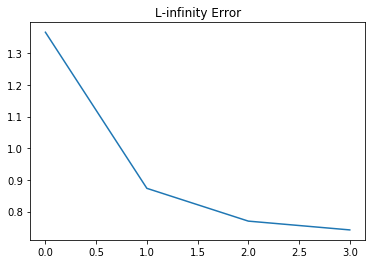

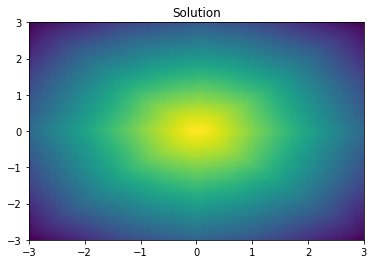

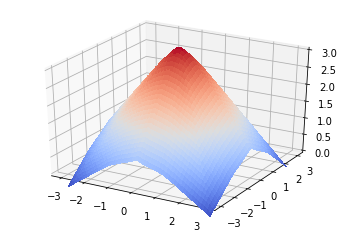

100%|██████████| 6000/6000 [00:18<00:00, 318.52it/s]


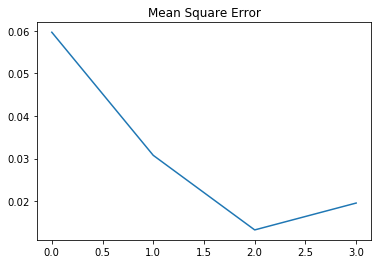

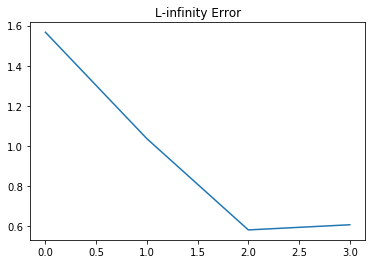

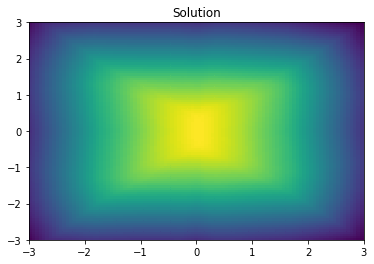

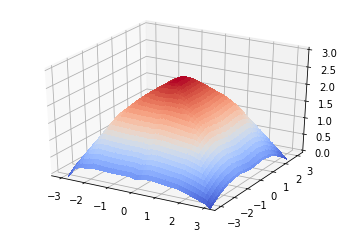

100%|██████████| 16000/16000 [00:44<00:00, 356.17it/s]


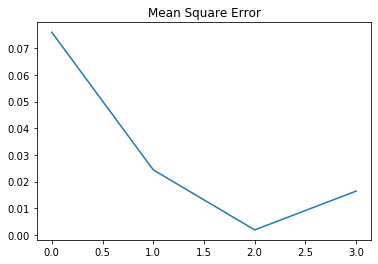

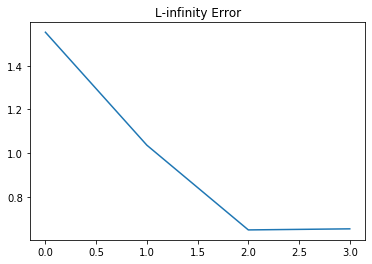

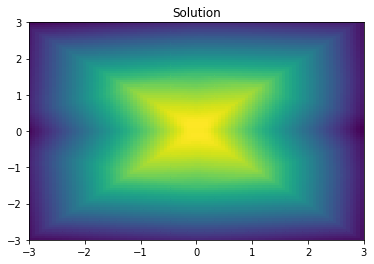

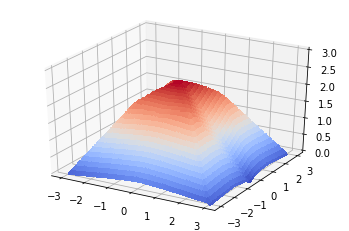

In [18]:
from Training.training import train
from error_test.cube_error import error_cube

MSE_history = torch.zeros([n_experiments, rounds])
L_inf_error_history = torch.zeros([n_experiments, rounds])
run_times = torch.zeros([n_experiments])

# For reproducibility
torch.manual_seed(0)

for j in range(n_experiments):
    
    domain = data_gen_cube(side_length, dim_list[j])
    
    if len(arch_list[j]) == 2:        
        NN = FCFF_3L([dim_list[j]] + arch_list[j])
    else:
        NN = FCFF_4L([dim_list[j]] + arch_list[j])
    
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
    time = 0.
    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta'] = delta_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        t0 = t()
        total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
        time += t() - t0
        
        MC_points = int(1e6) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_cube(NN, side_length, MC_points)
        
        MSE_history[j,i] = MSE
        L_inf_error_history[j,i] = L_inf
    
    run_times[j] = time
    
    plt.plot(MSE_history[j])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(L_inf_error_history[j])
    plt.title('L-infinity Error')
    plt.show()
    
    X_axis = 0
    Y_axis = 1

    plot_2d_proj(X_axis, Y_axis, NN, 100, side_length)


In [19]:
import pandas as pd
import numpy as np

training_features = pd.DataFrame({'Dimension': dim_list,
                               'Architecture': arch_list,
                               'delta': delta_list,
                               'alpha': alpha_list,
                               'N': N_col_list, 
                               'N_b': N_b_list,
                               'Iterations': num_iterations_list,})
run_T = pd.DataFrame({'Runtime (s)': np.array(run_times)}).astype('int')

results_MSE = pd.DataFrame(np.array(MSE_history))
results_Linf = pd.DataFrame(np.array(L_inf_error_history))


display('Mean Square Error', training_features.join(results_MSE).join(run_T).transpose())
display('L-infinity Error', training_features.join(results_Linf).join(run_T).transpose())


# One table
MSE = np.expand_dims(np.array(MSE_history[:,-1]), axis = 1)
L_inf_error = np.expand_dims(np.array(L_inf_error_history[:,-1]), axis = 1)
errors = np.concatenate((MSE, L_inf_error), axis = 1)
results = pd.DataFrame(errors,  columns = ['MSE', 'L_inf'])

display(training_features.join(results).join(run_T).transpose())

'Mean Square Error'

,0,1,2,3,4,5
Dimension,5,5,5,8,8,8
Architecture,"[30, 20]","[30, 20, 10]","[30, 20, 10]","[50, 40]","[40, 30, 20]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 4000, 5000, 8000]","[6000, 6000, 6000, 6000]","[6000, 6000, 6000, 6000]","[6000, 8000, 10000, 16000]"
0,0.076097,0.082201,0.09965,0.063493,0.059677,0.076045
1,0.016533,0.021449,0.012862,0.02937,0.030745,0.024409
2,0.009491,0.007574,0.001444,0.031494,0.013215,0.001865


'L-infinity Error'

,0,1,2,3,4,5
Dimension,5,5,5,8,8,8
Architecture,"[30, 20]","[30, 20, 10]","[30, 20, 10]","[50, 40]","[40, 30, 20]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 4000, 5000, 8000]","[6000, 6000, 6000, 6000]","[6000, 6000, 6000, 6000]","[6000, 8000, 10000, 16000]"
0,1.356018,1.418459,1.459089,1.366771,1.566718,1.553385
1,0.6201,0.6681,0.751561,0.873417,1.037058,1.036697
2,0.543409,0.551512,0.351398,0.769804,0.582942,0.649117


,0,1,2,3,4,5
Dimension,5,5,5,8,8,8
Architecture,"[30, 20]","[30, 20, 10]","[30, 20, 10]","[50, 40]","[40, 30, 20]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 4000, 5000, 8000]","[6000, 6000, 6000, 6000]","[6000, 6000, 6000, 6000]","[6000, 8000, 10000, 16000]"
MSE,0.015887,0.007979,0.011037,0.042152,0.019531,0.016435
L_inf,0.722491,0.509269,0.542349,0.741995,0.608592,0.654017
Runtime (s),27,28,45,58,77,126


In [21]:
display(training_features.join(results_MSE).join(run_T).to_latex())

display(training_features.join(results_Linf).join(run_T).to_latex())

display(training_features.join(results).join(run_T).transpose().to_latex())

'\\begin{tabular}{lrllllllrrrrr}\n\\toprule\n & Dimension & Architecture & delta & alpha & N & N_b & Iterations & 0 & 1 & 2 & 3 & Runtime (s) \\\\\n\\midrule\n0 & 5 & [30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 0.076097 & 0.016533 & 0.009491 & 0.015887 & 27 \\\\\n1 & 5 & [30, 20, 10] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 0.082201 & 0.021449 & 0.007574 & 0.007979 & 28 \\\\\n2 & 5 & [30, 20, 10] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 4000, 5000, 8000] & 0.099650 & 0.012862 & 0.001444 & 0.011037 & 45 \\\\\n3 & 8 & [50, 40] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [6000, 6000, 6000, 6000] & 0.063493 & 0.029370 & 0.031494 & 0.042152 & 58 \\\\\n4 & 8 & [40, 30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 

'\\begin{tabular}{lrllllllrrrrr}\n\\toprule\n & Dimension & Architecture & delta & alpha & N & N_b & Iterations & 0 & 1 & 2 & 3 & Runtime (s) \\\\\n\\midrule\n0 & 5 & [30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 1.356018 & 0.620100 & 0.543409 & 0.722491 & 27 \\\\\n1 & 5 & [30, 20, 10] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 1.418459 & 0.668100 & 0.551512 & 0.509269 & 28 \\\\\n2 & 5 & [30, 20, 10] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 4000, 5000, 8000] & 1.459089 & 0.751561 & 0.351398 & 0.542349 & 45 \\\\\n3 & 8 & [50, 40] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [6000, 6000, 6000, 6000] & 1.366771 & 0.873417 & 0.769804 & 0.741995 & 58 \\\\\n4 & 8 & [40, 30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 

'\\begin{tabular}{lllllll}\n\\toprule\n & 0 & 1 & 2 & 3 & 4 & 5 \\\\\n\\midrule\nDimension & 5 & 5 & 5 & 8 & 8 & 8 \\\\\nArchitecture & [30, 20] & [30, 20, 10] & [30, 20, 10] & [50, 40] & [40, 30, 20] & [40, 30, 20] \\\\\ndelta & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] \\\\\nalpha & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] \\\\\nN & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] \\\\\nN_b & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] \\\\\nIterations & [3000, 3000, 3000, 3000] & [3000, 3000, 3000, 3000] & [3000, 4000, 5000, 8000] & [6000, 6000, 6000, 6000] & [6000, 6000, 6000, 6000] & [6000, 8000, 10000, 16000] \\\\\nMSE & 0.015887 & 0.00

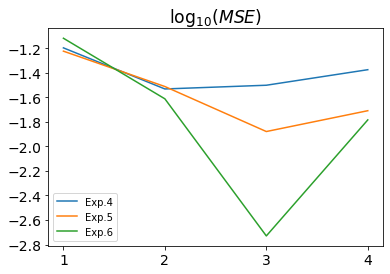

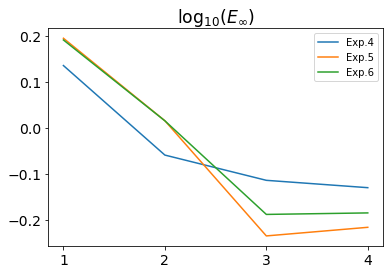

In [22]:
from mpl_toolkits.axes_grid1 import host_subplot

ax = host_subplot(111)
for i in range(3,MSE_history.shape[0]):
    x = np.arange(rounds) + 1
    MSE_log10 =torch.log10(MSE_history[i])
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x, MSE_log10, label = text)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.legend()
plt.show()

ax = host_subplot(111)
for i in range(3,L_inf_error_history.shape[0]):
    L_inf_log10 = torch.log10(L_inf_error_history[i])
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x, L_inf_log10, label = text)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.legend()
plt.show()